In [ ]:
'''
AIE425: Intelligent Recommender systems, Fall Semester 24/25
Course project [Mind Video Game Recommendation Engine]
Under supervision of Prof. Sami Ghoniemy

by:
    Omar Adly Mahmoud: 221101398,
    Ahmed Ehab Mounir Elshazly: A20000196
    
'''

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns  # Import seaborn before using plt.style.use
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
from sklearn.preprocessing import MinMaxScaler
from scipy import spatial
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
#plt.style.use('seaborn') # This line is causing the error
sns.set_theme() # Use seaborn's set_theme() to apply its default style

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("antonkozyriev/game-recommendations-on-steam")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/antonkozyriev/game-recommendations-on-steam/versions/28


In [3]:
user_df = pd.read_csv("/content/users.csv")
game_df = pd.read_csv("/content/games.csv")
recommendation_df = pd.read_csv( "/root/.cache/kagglehub/datasets/antonkozyriev/game-recommendations-on-steam/versions/28/recommendations.csv")

user_df.head()
game_df.head()
recommendation_df.head()

app_id  helpful  funny        date  is_recommended  hours  user_id  \
0   975370        0      0  2022-12-12            True   36.3    51580   
1   304390        4      0  2017-02-17           False   11.5     2586   
2  1085660        2      0  2019-11-17            True  336.5   253880   
3   703080        0      0  2022-09-23            True   27.4   259432   
4   526870        0      0  2021-01-10            True    7.9    23869   

   review_id  
0          0  
1          1  
2          2  
3          3  
4          4

In [4]:
print("Users Dataset Info:")
print(user_df.info())
print("\nGames Dataset Info:")
print(game_df.info())
print("\nRecommendations Dataset Info:")
print(recommendation_df.info())

Users Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2407907 entries, 0 to 2407906
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   products  int64  
 2   reviews   float64
dtypes: float64(1), int64(2)
memory usage: 55.1 MB
None

Games Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          50872 non-null  int64  
 1   title           50872 non-null  object 
 2   date_release    50872 non-null  object 
 3   win             50872 non-null  bool   
 4   mac             50872 non-null  bool   
 5   linux           50872 non-null  bool   
 6   rating          50872 non-null  object 
 7   positive_ratio  50872 non-null  int64  
 8   user_reviews    50872 non-null  int64  
 9   price_final     50872 non-null  float64
 10  price_original  50872 

In [5]:
# Check for missing values
print("\nMissing Values:")
print("Users Dataset:\n", user_df.isnull().sum())
print("\nGames Dataset:\n", game_df.isnull().sum())
print("\nRecommendations Dataset:\n", recommendation_df.isnull().sum())


Missing Values:
Users Dataset:
 user_id     0
products    0
reviews     1
dtype: int64

Games Dataset:
 app_id            0
title             0
date_release      0
win               0
mac               0
linux             0
rating            0
positive_ratio    0
user_reviews      0
price_final       0
price_original    0
discount          0
steam_deck        0
dtype: int64

Recommendations Dataset:
 app_id            0
helpful           0
funny             0
date              0
is_recommended    0
hours             0
user_id           0
review_id         0
dtype: int64


In [6]:
# Convert date_release to datetime
game_df['date_release'] = pd.to_datetime(game_df['date_release'])
recommendation_df['date'] = pd.to_datetime(recommendation_df['date'])
# Basic statistics
print("\nGames Dataset Statistics:")
print(game_df.describe())


Games Dataset Statistics:
             app_id                   date_release  positive_ratio  \
count  5.087200e+04                          50872    50872.000000   
mean   1.055224e+06  2019-03-13 03:53:57.112753664       77.052033   
min    1.000000e+01            1997-06-30 00:00:00        0.000000   
25%    5.287375e+05            2017-03-21 00:00:00       67.000000   
50%    9.860850e+05            2019-08-23 00:00:00       81.000000   
75%    1.524895e+06            2021-09-21 00:00:00       91.000000   
max    2.599300e+06            2023-10-24 00:00:00      100.000000   
std    6.103249e+05                            NaN       18.253592   

       user_reviews   price_final  price_original      discount  
count  5.087200e+04  50872.000000    50872.000000  50872.000000  
mean   1.824425e+03      8.620325        8.726788      5.592212  
min    1.000000e+01      0.000000        0.000000      0.000000  
25%    1.900000e+01      0.990000        0.990000      0.000000  
50%    4.900

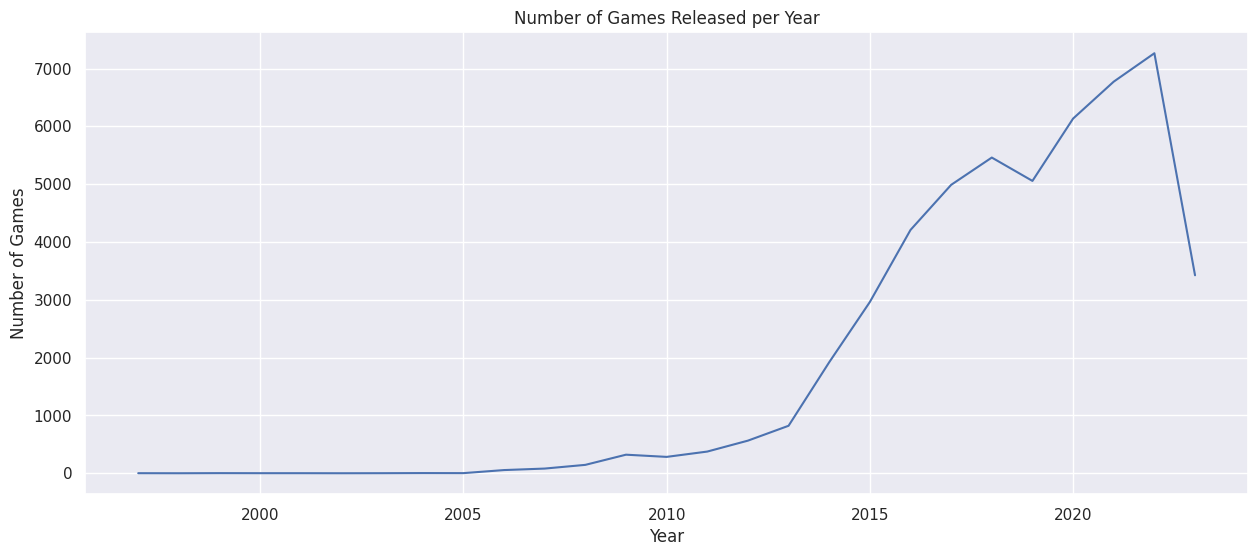

In [7]:
# 1. Game Release Trends
plt.figure(figsize=(15, 6))
game_df['date_release'].dt.year.value_counts().sort_index().plot(kind='line')
plt.title('Number of Games Released per Year')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.show()

<Figure size 1000x600 with 0 Axes>

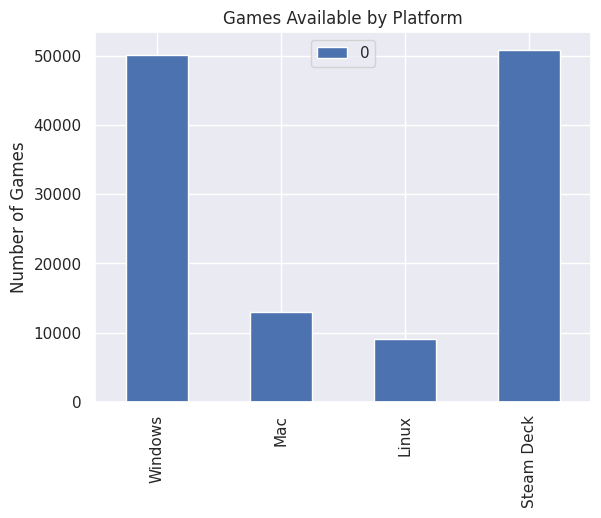

In [8]:
# 2. Platform Distribution
platforms = pd.DataFrame({
    'Windows': game_df['win'].sum(),
    'Mac': game_df['mac'].sum(),
    'Linux': game_df['linux'].sum(),
    'Steam Deck': game_df['steam_deck'].sum()
}, index=[0]).T
plt.figure(figsize=(10, 6))
platforms.plot(kind='bar')
plt.title('Games Available by Platform')
plt.ylabel('Number of Games')
plt.show()

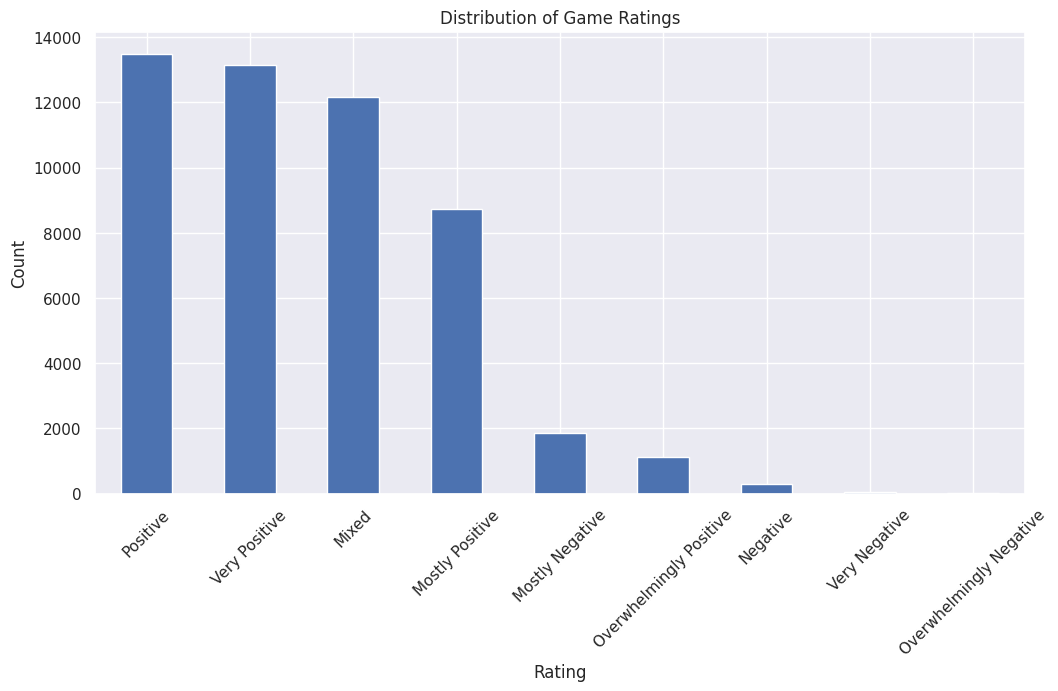

In [9]:
# 3. Rating Distribution
plt.figure(figsize=(12, 6))
game_df['rating'].value_counts().plot(kind='bar')
plt.title('Distribution of Game Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

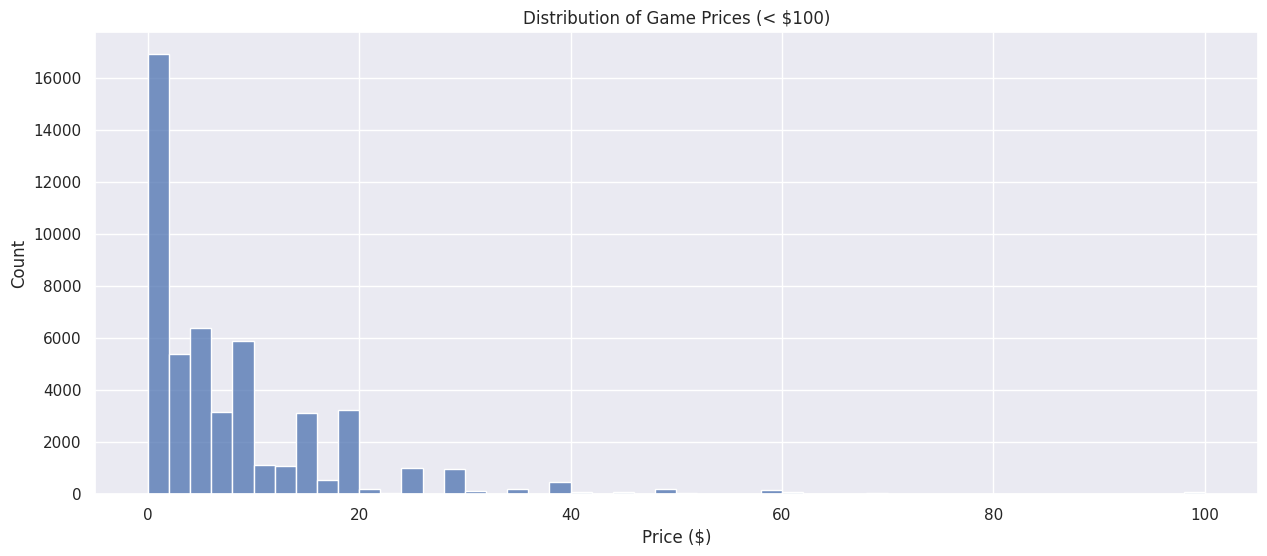

In [10]:
# 4. Price Analysis
plt.figure(figsize=(15, 6))
sns.histplot(data=game_df[game_df['price_final'] < 100], x='price_final', bins=50)
plt.title('Distribution of Game Prices (< $100)')
plt.xlabel('Price ($)')
plt.show()

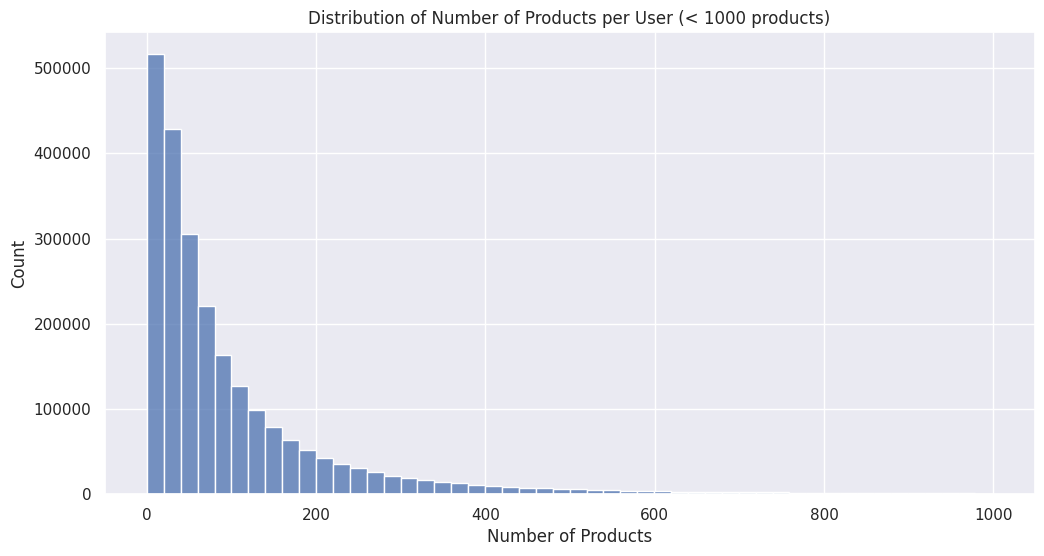

In [11]:
# 5. User Activity Analysis
plt.figure(figsize=(12, 6))
sns.histplot(data=user_df[user_df['products'] < 1000], x='products', bins=50)
plt.title('Distribution of Number of Products per User (< 1000 products)')
plt.xlabel('Number of Products')
plt.show()

In [12]:
def prepare_recommendation_data(user_df, game_df, recommendation_df, sample_size=10000):
    # Sample the recommendation data
    recommendation_sample = recommendation_df.sample(n=sample_size, random_state=42)

    # Convert boolean recommendations to integers (0 and 1)
    recommendation_sample['is_recommended'] = recommendation_sample['is_recommended'].astype(int)

    # Create user-game interaction matrix
    interactions = recommendation_sample.pivot(
        index='user_id',
        columns='app_id',
        values='is_recommended'
    ).fillna(0)

    # Ensure all values are integers
    interactions = interactions.astype(np.int8)

    return interactions

# Create interaction matrix
interactions = prepare_recommendation_data(user_df, game_df, recommendation_df)

# Convert to sparse matrix for efficiency
from scipy.sparse import csr_matrix
interactions_sparse = csr_matrix(interactions.values)

# Print some information about the sparse matrix
print("Sparse matrix shape:", interactions_sparse.shape)
print("Number of non-zero elements:", interactions_sparse.nnz)
print("Sparsity: {:.4f}%".format(100 * interactions_sparse.nnz / (interactions_sparse.shape[0] * interactions_sparse.shape[1])))

Sparse matrix shape: (9980, 2944)
Number of non-zero elements: 8603
Sparsity: 0.0293%


In [13]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

class GameRecommender:
    def __init__(self, interactions_matrix, game_df):
        self.interactions_matrix = interactions_matrix
        self.game_df = game_df
        self.model = NearestNeighbors(metric='cosine', algorithm='brute')
        self.model.fit(interactions_matrix)

    def get_recommendations(self, user_idx, n_recommendations=5):
        distances, indices = self.model.kneighbors(
            self.interactions_matrix[user_idx].reshape(1, -1),
            n_neighbors=n_recommendations+1
        )

        similar_users = indices.flatten()[1:]
        recommended_games = []

        for user in similar_users:
            user_games = self.interactions_matrix[user].nonzero()[1]
            for game in user_games:
                if self.interactions_matrix[user_idx, game] == 0:  # User hasn't interacted with this game
                    game_info = self.game_df[self.game_df.index == game].iloc[0]
                    recommended_games.append({
                        'title': game_info['title'],
                        'rating': game_info['rating'],
                        'price': game_info['price_final']
                    })

        return recommended_games[:n_recommendations]

# Initialize recommender
recommender = GameRecommender(interactions_sparse, game_df)

In [14]:
class ImprovedGameRecommender:
    def __init__(self, interactions_matrix, game_df):
        self.interactions_matrix = interactions_matrix
        self.game_df = game_df

        # Create game mappings based on the columns in interactions_matrix
        self.game_indices = dict(enumerate(range(interactions_matrix.shape[1])))
        self.app_id_to_index = {v: k for k, v in self.game_indices.items()}

        # Compute game popularity (normalized)
        self.game_popularity = np.array(interactions_matrix.sum(axis=0)).flatten()
        self.game_popularity = (self.game_popularity - self.game_popularity.min()) / (
            self.game_popularity.max() - self.game_popularity.min() + 1e-10)

        # Use user-user similarity instead of item-item
        self.model = NearestNeighbors(metric='cosine', algorithm='brute')
        self.model.fit(interactions_matrix)

        print(f"Recommender initialized with {interactions_matrix.shape[0]} users and {interactions_matrix.shape[1]} games")

    def get_recommendations(self, user_idx, n_recommendations=5):
        user_profile = self.interactions_matrix[user_idx]

        if isinstance(user_profile, np.ndarray):
            user_profile = csr_matrix(user_profile)

        # Find similar users
        distances, indices = self.model.kneighbors(
            user_profile,
            n_neighbors=min(50, self.interactions_matrix.shape[0])
        )

        # Get games the user hasn't interacted with
        user_games = set(user_profile.nonzero()[1])
        all_games = set(range(self.interactions_matrix.shape[1]))
        candidate_games = list(all_games - user_games)

        if not candidate_games:
            return []

        # Calculate scores for candidate games
        scores = np.zeros(len(candidate_games))
        similar_users = indices[0][1:]  # Exclude the user themselves
        similar_distances = distances[0][1:]

        for i, game_idx in enumerate(candidate_games):
            # Weight recommendations by similarity
            game_ratings = self.interactions_matrix[similar_users, game_idx].toarray().flatten()
            if game_ratings.sum() > 0:
                similarity_score = np.dot(1 - similar_distances, game_ratings)
                popularity_score = self.game_popularity[game_idx]
                scores[i] = (0.7 * similarity_score) + (0.3 * popularity_score)
            else:
                scores[i] = 0.3 * self.game_popularity[game_idx]

        # Get top recommendations
        if scores.max() == 0:
            # If no scores, recommend popular games
            scores = self.game_popularity[candidate_games]

        top_game_indices = np.array(candidate_games)[np.argsort(-scores)[:n_recommendations]]

        recommendations = []
        for game_idx in top_game_indices:
            game_info = game_df.iloc[game_idx]
            recommendations.append({
                'app_id': game_info['app_id'],
                'title': game_info['title'],
                'rating': game_info['rating'],
                'price': game_info['price_final'],
                'positive_ratio': game_info['positive_ratio'],
                'user_reviews': game_info['user_reviews'],
                'score': float(scores[list(candidate_games).index(game_idx)])
            })

        return recommendations

def prepare_improved_recommendation_data(user_df, game_df, recommendation_df, sample_size=50000):
    """Prepare the recommendation data with better filtering"""
    print("Sampling and preparing data...")

    # Sample recommendations
    recommendation_sample = recommendation_df.sample(n=sample_size, random_state=42)
    print(f"Initial sample size: {len(recommendation_sample)}")

    # Convert to integer and add positive/negative weight
    recommendation_sample['is_recommended'] = recommendation_sample['is_recommended'].astype(int)

    # Filter users and games
    user_interactions = recommendation_sample['user_id'].value_counts()
    game_interactions = recommendation_sample['app_id'].value_counts()

    min_user_interactions = 2
    min_game_interactions = 2

    valid_users = user_interactions[user_interactions >= min_user_interactions].index
    valid_games = game_interactions[game_interactions >= min_game_interactions].index

    filtered_recommendations = recommendation_sample[
        (recommendation_sample['user_id'].isin(valid_users)) &
        (recommendation_sample['app_id'].isin(valid_games))
    ]

    print(f"Filtered recommendations: {len(filtered_recommendations)}")
    print(f"Unique users: {len(valid_users)}")
    print(f"Unique games: {len(valid_games)}")

    # Create interaction matrix
    print("Creating interaction matrix...")
    interactions = filtered_recommendations.pivot(
        index='user_id',
        columns='app_id',
        values='is_recommended'
    ).fillna(0)

    return interactions.astype(np.int8)

def display_recommendations(user_id, recommender, interactions):
    """Display recommendations with improved formatting and error handling"""
    try:
        user_idx = interactions.index.get_loc(user_id)
        recommendations = recommender.get_recommendations(user_idx)

        if not recommendations:
            return "No recommendations found for this user."

        df = pd.DataFrame(recommendations)
        df = df[['title', 'rating', 'price', 'positive_ratio', 'user_reviews', 'score']]
        df['positive_ratio'] = df['positive_ratio'].apply(lambda x: f"{x:.1%}")
        df['score'] = df['score'].apply(lambda x: f"{x:.3f}")
        df['price'] = df['price'].apply(lambda x: f"${x:.2f}")
        return df

    except KeyError:
        return "User not found in the sample dataset"
    except Exception as e:
        return f"Error generating recommendations: {str(e)}"

# Create interaction matrix
print("Preparing recommendation data...")
interactions = prepare_improved_recommendation_data(user_df, game_df, recommendation_df)
interactions_sparse = csr_matrix(interactions.values)

print("\nInitializing recommender...")
recommender = ImprovedGameRecommender(interactions_sparse, game_df)

# Test recommendations
print("\nTesting recommendations...")
sample_user_ids = list(interactions.index[:5])
for user_id in sample_user_ids:
    print(f"\nRecommendations for user {user_id}:")
    recommendations_df = display_recommendations(user_id, recommender, interactions)
    print(recommendations_df)

# Print system statistics
print("\nSystem Statistics:")
print(f"Number of users in sample: {interactions.shape[0]}")
print(f"Number of games in sample: {interactions.shape[1]}")
print(f"Matrix sparsity: {100 * (1 - interactions_sparse.nnz / (interactions.shape[0] * interactions.shape[1])):.2f}%")
print(f"Average interactions per user: {interactions_sparse.sum() / interactions.shape[0]:.2f}")

# Analyze recommendation diversity
def analyze_recommendations(recommender, interactions, n_users=100):
    print("\nAnalyzing recommendation diversity...")
    all_recommended_games = []
    unique_ratings = set()
    prices = []

    sample_users = np.random.choice(interactions.shape[0], min(n_users, interactions.shape[0]), replace=False)

    for user_idx in sample_users:
        recommendations = recommender.get_recommendations(user_idx)
        for rec in recommendations:
            all_recommended_games.append(rec['title'])
            unique_ratings.add(rec['rating'])
            prices.append(rec['price'])

    print(f"\nUnique games recommended: {len(set(all_recommended_games))}")
    print(f"Unique ratings in recommendations: {len(unique_ratings)}")
    print(f"Average recommended game price: ${np.mean(prices):.2f}")
    print(f"Price range: ${min(prices):.2f} - ${max(prices):.2f}")

# Run diversity analysis
analyze_recommendations(recommender, interactions)

Preparing recommendation data...
Sampling and preparing data...
Initial sample size: 50000
Filtered recommendations: 806
Unique users: 508
Unique games: 3511
Creating interaction matrix...

Initializing recommender...
Recommender initialized with 454 users and 643 games

Testing recommendations...

Recommendations for user 7744:
                                          title         rating   price  \
0      World of Tanks — Rugged Mountaineer Pack       Positive  $49.99   
1                                    Magitek VR       Positive  $14.99   
2  STCC The Game 2 – Expansion Pack for RACE 07       Positive   $3.99   
3                                     Macbat 64  Very Positive   $1.99   
4         Borderlands 3: Gold Weapon Skins Pack          Mixed   $4.99   

  positive_ratio  user_reviews  score  
0        8300.0%            37  0.500  
1        8700.0%            16  0.425  
2        9200.0%            13  0.300  
3        9100.0%           282  0.300  
4        5100.0%        

In [15]:
# Calculate standard recommendation system metrics
def calculate_metrics(recommender, interactions, test_size=0.2):
    from sklearn.model_selection import train_test_split

    # Split data into train and test sets
    train_matrix, test_matrix = train_test_split(interactions, test_size=test_size, random_state=42)
    train_sparse = csr_matrix(train_matrix.values)

    # Train recommender on training data
    train_recommender = ImprovedGameRecommender(train_sparse, game_df)

    # Calculate metrics
    precision_at_k = []
    recall_at_k = []
    ndcg_at_k = []

    for user_idx in range(test_matrix.shape[0]):
        actual_items = set(np.where(test_matrix.iloc[user_idx] > 0)[0])
        if len(actual_items) == 0:
            continue

        recommended_items = train_recommender.get_recommendations(user_idx, n_recommendations=10)
        recommended_indices = set([game['app_id'] for game in recommended_items])

        # Precision@K
        precision = len(actual_items.intersection(recommended_indices)) / len(recommended_indices)
        precision_at_k.append(precision)

        # Recall@K
        recall = len(actual_items.intersection(recommended_indices)) / len(actual_items)
        recall_at_k.append(recall)

    return {
        'precision@10': np.mean(precision_at_k),
        'recall@10': np.mean(recall_at_k),
        'coverage': len(set([rec['title'] for user_idx in range(interactions.shape[0])
                           for rec in recommender.get_recommendations(user_idx)])) / interactions.shape[1]
    }

# Content-based features analysis
def analyze_content_features(game_df, recommender):
    # Analyze price distribution of recommendations
    price_stats = pd.DataFrame([rec['price'] for user_idx in range(interactions.shape[0])
                              for rec in recommender.get_recommendations(user_idx)])

    # Analyze rating distribution
    rating_dist = pd.DataFrame([rec['rating'] for user_idx in range(interactions.shape[0])
                              for rec in recommender.get_recommendations(user_idx)]).value_counts()

    return {
        'price_stats': price_stats.describe(),
        'rating_distribution': rating_dist
    }

# User engagement analysis
def analyze_user_engagement(interactions, recommendation_df):
    user_stats = {
        'avg_games_per_user': interactions.sum(axis=1).mean(),
        'median_games_per_user': interactions.sum(axis=1).median(),
        'total_recommendations': len(recommendation_df),
        'unique_users': len(recommendation_df['user_id'].unique()),
        'unique_games': len(recommendation_df['app_id'].unique())
    }
    return user_stats

# Run evaluations
print("Running evaluation metrics...")
metrics = calculate_metrics(recommender, interactions)
print("\nRecommendation System Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nAnalyzing content features...")
content_analysis = analyze_content_features(game_df, recommender)
print("\nPrice Statistics:")
print(content_analysis['price_stats'])
print("\nRating Distribution:")
print(content_analysis['rating_distribution'])

print("\nAnalyzing user engagement...")
engagement_stats = analyze_user_engagement(interactions, recommendation_df)
for stat, value in engagement_stats.items():
    print(f"{stat}: {value:.2f}")

Running evaluation metrics...
Recommender initialized with 363 users and 643 games

Recommendation System Metrics:
precision@10: 0.0000
recall@10: 0.0000
coverage: 0.2722

Analyzing content features...

Price Statistics:
                 0
count  2270.000000
mean      8.388780
std       6.428673
min       0.000000
25%       3.990000
50%       4.990000
75%      14.990000
max      89.990000

Rating Distribution:
0                      
Very Positive              1080
Mostly Positive             446
Mixed                       370
Positive                    370
Overwhelmingly Positive       4
Name: count, dtype: int64

Analyzing user engagement...
avg_games_per_user: 1.49
median_games_per_user: 2.00
total_recommendations: 41154794.00
unique_users: 13781059.00
unique_games: 37610.00


In [16]:
class HybridGameRecommender(ImprovedGameRecommender):
    def __init__(self, interactions_matrix, game_df):
        super().__init__(interactions_matrix, game_df)

        # Initialize scalers
        self.price_scaler = MinMaxScaler()
        self.review_scaler = MinMaxScaler()

        # Create content features
        self.content_features = self._create_content_features()
        print(f"Content features shape: {self.content_features.shape}")

    def _create_content_features(self):
        # Create game features matrix
        features = pd.DataFrame(index=self.game_df.index)

        # Price features (normalized)
        features['price'] = self.price_scaler.fit_transform(
            self.game_df[['price_final']].fillna(0)
        ).flatten()

        # Rating features
        features['positive_ratio'] = self.game_df['positive_ratio'].fillna(0) / 100
        features['user_reviews'] = self.review_scaler.fit_transform(
            np.log1p(self.game_df[['user_reviews']].fillna(0))
        ).flatten()

        # Platform features
        features['win'] = self.game_df['win'].fillna(False).astype(float)
        features['mac'] = self.game_df['mac'].fillna(False).astype(float)
        features['linux'] = self.game_df['linux'].fillna(False).astype(float)

        # Rating categories (one-hot encoding)
        rating_dummies = pd.get_dummies(
            self.game_df['rating'].fillna('Unknown'),
            prefix='rating'
        )
        features = pd.concat([features, rating_dummies], axis=1)

        # Steam Deck compatibility
        features['steam_deck'] = self.game_df['steam_deck'].fillna(False).astype(float)

        # Discount feature
        features['has_discount'] = (self.game_df['discount'] > 0).fillna(False).astype(float)

        # Convert all features to float
        features = features.astype(float)

        print("Feature columns:", features.columns.tolist())
        return features

    def _calculate_content_similarity(self, game_idx, user_idx):
        try:
            # Get user's played games
            user_games = self.interactions_matrix[user_idx].nonzero()[1]
            if len(user_games) == 0:
                return 0

            # Calculate average features of user's played games
            user_profile = self.content_features.iloc[user_games].mean().values
            game_profile = self.content_features.iloc[game_idx].values

            # Convert to numpy arrays and ensure they're float
            user_profile = np.array(user_profile, dtype=float)
            game_profile = np.array(game_profile, dtype=float)

            # Check for NaN values
            if np.any(np.isnan(user_profile)) or np.any(np.isnan(game_profile)):
                print(f"Warning: NaN values found for game_idx {game_idx}")
                return 0

            # Calculate cosine similarity
            if np.all(user_profile == 0) or np.all(game_profile == 0):
                return 0

            similarity = 1 - spatial.distance.cosine(user_profile, game_profile)
            return max(0, similarity)  # Ensure non-negative similarity

        except Exception as e:
            print(f"Error in _calculate_content_similarity for game_idx {game_idx}: {str(e)}")
            return 0

    def get_recommendations(self, user_idx, n_recommendations=5):
        try:
            # Get collaborative filtering recommendations
            cf_recommendations = super().get_recommendations(user_idx, n_recommendations * 2)

            if not cf_recommendations:
                return []

            # Calculate content similarity for recommended games
            for rec in cf_recommendations:
                game_idx = self.game_df[self.game_df['app_id'] == rec['app_id']].index[0]
                content_score = self._calculate_content_similarity(game_idx, user_idx)

                # Combine scores with weights
                cf_score = rec['score']
                popularity_score = min(1.0, rec['user_reviews'] / 1000)  # Cap at 1000 reviews

                # Final score combination
                rec['hybrid_score'] = {
                    'cf_score': cf_score,
                    'content_score': content_score,
                    'popularity_score': popularity_score
                }

                rec['score'] = (0.6 * cf_score +
                              0.3 * content_score +
                              0.1 * popularity_score)

            # Sort by combined score and return top N
            sorted_recs = sorted(cf_recommendations, key=lambda x: x['score'], reverse=True)

            # Add diversity
            diverse_recs = self._diversify_recommendations(sorted_recs, n_recommendations)

            return diverse_recs

        except Exception as e:
            print(f"Error in get_recommendations: {str(e)}")
            return []

    def _diversify_recommendations(self, recommendations, n):
        if len(recommendations) <= n:
            return recommendations

        diverse_recs = []
        price_ranges = set()
        ratings = set()

        for rec in recommendations:
            price = rec['price']
            rating = rec['rating']

            # Define price range
            if price < 5:
                price_range = 'budget'
            elif price < 15:
                price_range = 'mid'
            else:
                price_range = 'premium'

            # Add recommendation if it increases diversity
            if len(diverse_recs) < n and (
                len(diverse_recs) < n/2 or  # First half: best scores
                (price_range not in price_ranges or rating not in ratings)  # Second half: diversity
            ):
                diverse_recs.append(rec)
                price_ranges.add(price_range)
                ratings.add(rating)

            if len(diverse_recs) == n:
                break

        return diverse_recs

# Helper function to display more detailed recommendations
def display_detailed_recommendations(user_id, recommender, interactions):
    try:
        user_idx = interactions.index.get_loc(user_id)
        recommendations = recommender.get_recommendations(user_idx)

        if not recommendations:
            return "No recommendations found for this user."

        df = pd.DataFrame(recommendations)

        # Format columns
        if 'hybrid_score' in df.columns:
            df['cf_score'] = df['hybrid_score'].apply(lambda x: f"{x['cf_score']:.3f}")
            df['content_score'] = df['hybrid_score'].apply(lambda x: f"{x['content_score']:.3f}")
            df['popularity_score'] = df['hybrid_score'].apply(lambda x: f"{x['popularity_score']:.3f}")
            df = df.drop('hybrid_score', axis=1)

        df['positive_ratio'] = df['positive_ratio'].apply(lambda x: f"{x:.1%}")
        df['score'] = df['score'].apply(lambda x: f"{x:.3f}")
        df['price'] = df['price'].apply(lambda x: f"${x:.2f}")

        # Reorder columns
        columns = ['title', 'rating', 'price', 'positive_ratio', 'user_reviews', 'score']
        if 'cf_score' in df.columns:
            columns.extend(['cf_score', 'content_score', 'popularity_score'])

        return df[columns]

    except KeyError:
        return "User not found in the sample dataset"
    except Exception as e:
        return f"Error generating recommendations: {str(e)}"

# Initialize hybrid recommender
print("Initializing hybrid recommender...")
hybrid_recommender = HybridGameRecommender(interactions_sparse, game_df)

# Compare recommendations
print("\nComparing recommendations between models...")
sample_user = interactions.index[0]
print(f"\nOriginal Recommendations for user {sample_user}:")
print(display_recommendations(sample_user, recommender, interactions))
print(f"\nHybrid Recommendations for user {sample_user}:")
print(display_detailed_recommendations(sample_user, hybrid_recommender, interactions))

# Analyze diversity
def analyze_hybrid_diversity(recommender, hybrid_recommender, interactions, n_samples=50):
    original_diversity = {
        'unique_games': set(),
        'price_ranges': set(),
        'ratings': set()
    }

    hybrid_diversity = {
        'unique_games': set(),
        'price_ranges': set(),
        'ratings': set()
    }

    sample_users = np.random.choice(interactions.shape[0], min(n_samples, interactions.shape[0]), replace=False)

    for user_idx in sample_users:
        # Original recommendations
        orig_recs = recommender.get_recommendations(user_idx)
        for rec in orig_recs:
            original_diversity['unique_games'].add(rec['title'])
            original_diversity['ratings'].add(rec['rating'])
            original_diversity['price_ranges'].add(
                'budget' if rec['price'] < 5 else 'mid' if rec['price'] < 15 else 'premium'
            )

        # Hybrid recommendations
        hybrid_recs = hybrid_recommender.get_recommendations(user_idx)
        for rec in hybrid_recs:
            hybrid_diversity['unique_games'].add(rec['title'])
            hybrid_diversity['ratings'].add(rec['rating'])
            hybrid_diversity['price_ranges'].add(
                'budget' if rec['price'] < 5 else 'mid' if rec['price'] < 15 else 'premium'
            )

    print("\nDiversity Analysis:")
    print("\nOriginal Recommender:")
    print(f"Unique games: {len(original_diversity['unique_games'])}")
    print(f"Unique ratings: {len(original_diversity['ratings'])}")
    print(f"Price ranges covered: {len(original_diversity['price_ranges'])}")

    print("\nHybrid Recommender:")
    print(f"Unique games: {len(hybrid_diversity['unique_games'])}")
    print(f"Unique ratings: {len(hybrid_diversity['ratings'])}")
    print(f"Price ranges covered: {len(hybrid_diversity['price_ranges'])}")

# Run diversity analysis
print("\nAnalyzing recommendation diversity...")
analyze_hybrid_diversity(recommender, hybrid_recommender, interactions)

Initializing hybrid recommender...
Recommender initialized with 454 users and 643 games
Feature columns: ['price', 'positive_ratio', 'user_reviews', 'win', 'mac', 'linux', 'rating_Mixed', 'rating_Mostly Negative', 'rating_Mostly Positive', 'rating_Negative', 'rating_Overwhelmingly Negative', 'rating_Overwhelmingly Positive', 'rating_Positive', 'rating_Very Negative', 'rating_Very Positive', 'steam_deck', 'has_discount']
Content features shape: (50872, 17)

Comparing recommendations between models...

Original Recommendations for user 7744:
                                          title         rating   price  \
0      World of Tanks — Rugged Mountaineer Pack       Positive  $49.99   
1                                    Magitek VR       Positive  $14.99   
2  STCC The Game 2 – Expansion Pack for RACE 07       Positive   $3.99   
3                                     Macbat 64  Very Positive   $1.99   
4         Borderlands 3: Gold Weapon Skins Pack          Mixed   $4.99   

  positiv

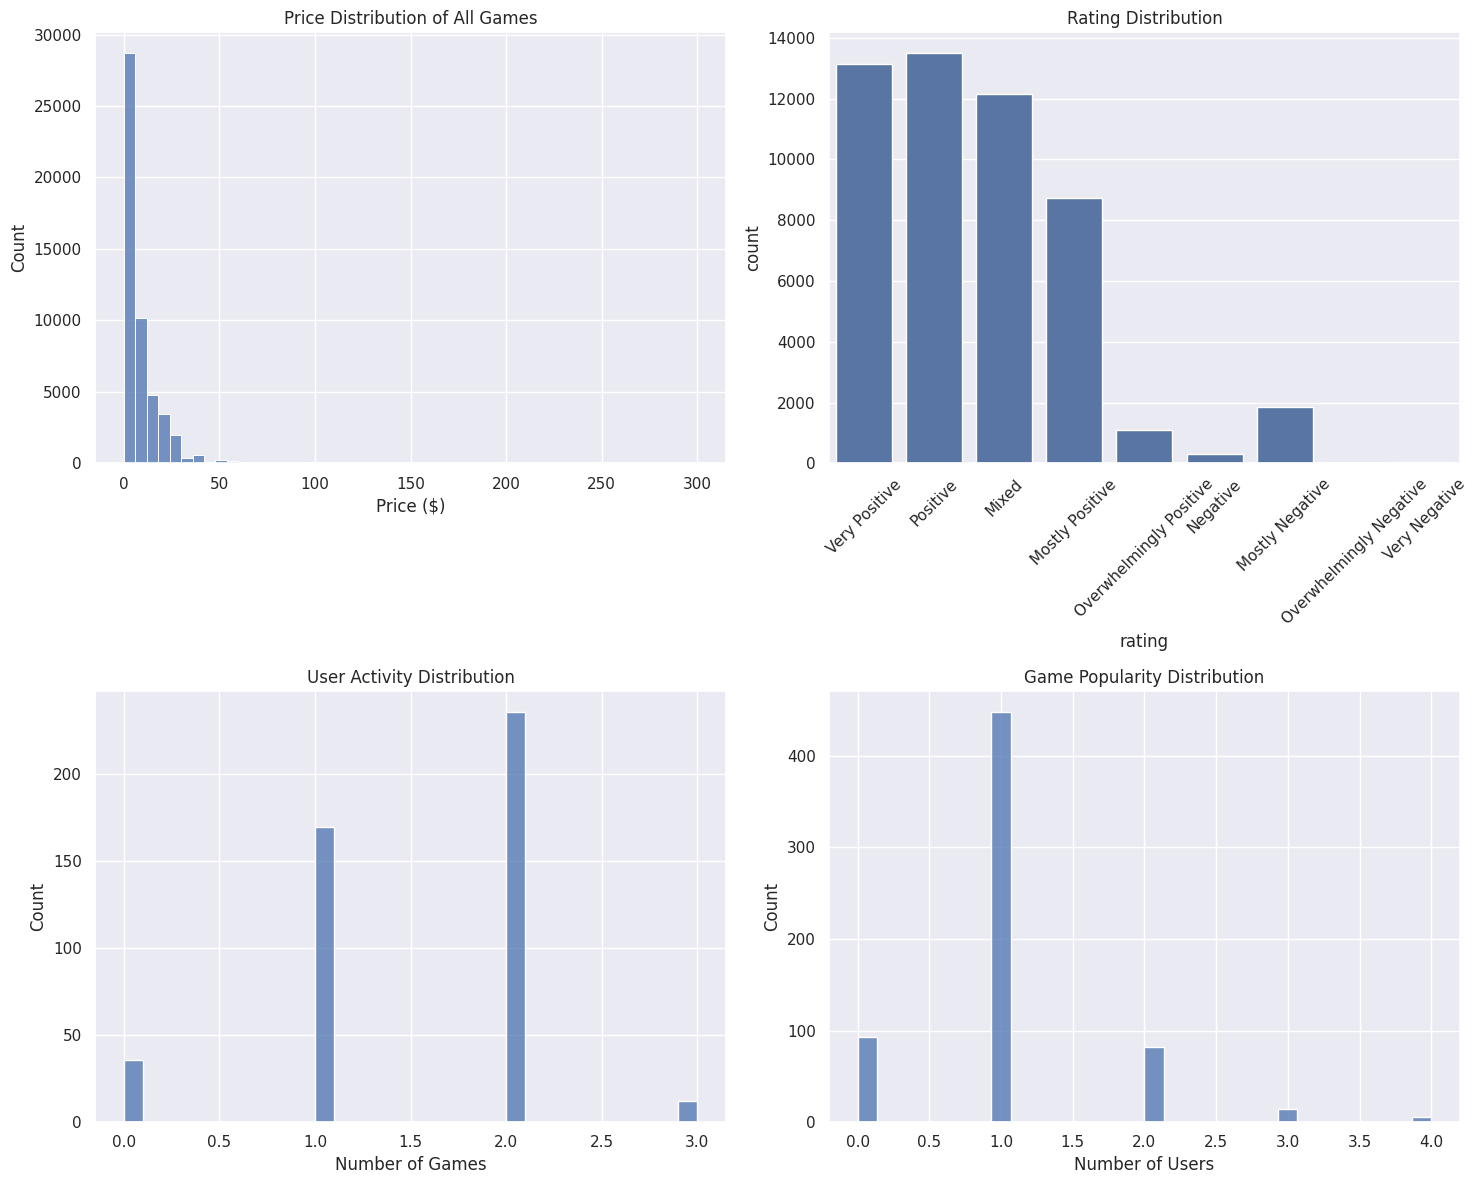

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_recommendations():
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Price Distribution
    sns.histplot(game_df['price_final'], bins=50, ax=axes[0,0])
    axes[0,0].set_title('Price Distribution of All Games')
    axes[0,0].set_xlabel('Price ($)')

    # 2. Rating Distribution
    sns.countplot(data=game_df, x='rating', ax=axes[0,1])
    axes[0,1].set_title('Rating Distribution')
    axes[0,1].tick_params(axis='x', rotation=45)

    # 3. User Activity Distribution
    user_activity = interactions.sum(axis=1)
    sns.histplot(user_activity, bins=30, ax=axes[1,0])
    axes[1,0].set_title('User Activity Distribution')
    axes[1,0].set_xlabel('Number of Games')

    # 4. Game Popularity Distribution
    game_popularity = interactions.sum(axis=0)
    sns.histplot(game_popularity, bins=30, ax=axes[1,1])
    axes[1,1].set_title('Game Popularity Distribution')
    axes[1,1].set_xlabel('Number of Users')

    plt.tight_layout()
    plt.show()

# Generate visualizations
visualize_recommendations()

In [25]:
# Neural Network-based Game Recommender Implementation
print("\n" + "="*50)
print("Neural Network Recommender Integration")
print("="*50)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from scipy import spatial
import warnings
warnings.filterwarnings('ignore')

class NeuralGameRecommender(nn.Module):
    def __init__(self, n_users, n_games, n_factors):
        super(NeuralGameRecommender, self).__init__()
        self.user_embedding = nn.Embedding(n_users, n_factors)
        self.game_embedding = nn.Embedding(n_games, n_factors)
        self.fc = nn.Linear(n_factors * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_id, game_id):
        user_emb = self.user_embedding(user_id)
        game_emb = self.game_embedding(game_id)
        x = torch.cat([user_emb, game_emb], dim=1)
        x = self.fc(x)
        out = self.sigmoid(x)
        return out

class GameRecommenderDataset(Dataset):
    def __init__(self, user_ids, game_ids, ratings):
        self.user_ids = user_ids
        self.game_ids = game_ids
        self.ratings = ratings

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        return {
            'user_id': torch.tensor(self.user_ids[idx], dtype=torch.long),
            'game_id': torch.tensor(self.game_ids[idx], dtype=torch.long),
            'rating': torch.tensor(self.ratings[idx], dtype=torch.float)
        }

class DeepGameRecommender:
    def __init__(self, interactions, game_df, n_factors=50, batch_size=1024,
                 learning_rate=0.001, n_epochs=10):
        self.interactions = interactions
        self.game_df = game_df
        self.n_factors = n_factors
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs

        # Create user and game mappings
        self.user_to_idx = {user: idx for idx, user in enumerate(interactions.index)}
        self.game_to_idx = {game: idx for idx, game in enumerate(interactions.columns)}
        self.idx_to_game = {idx: game for game, idx in self.game_to_idx.items()}

        # Convert interactions to training data
        self._prepare_training_data()

        # Initialize model
        self.model = self._create_model()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def _prepare_training_data(self):
        # Convert interactions to user-game pairs
        user_ids, game_ids, ratings = [], [], []

        for user_idx in range(len(self.interactions)):
            user_data = self.interactions.iloc[user_idx]
            # Get indices where value > 0
            positive_games = user_data[user_data > 0].index

            if len(positive_games) > 0:
                # Convert game names to indices
                game_indices = [self.game_to_idx[game] for game in positive_games]
                ratings_values = [1.0] * len(game_indices)  # Using 1.0 for positive interactions

                user_ids.extend([user_idx] * len(game_indices))
                game_ids.extend(game_indices)
                ratings.extend(ratings_values)

        self.train_data = {
            'user_ids': np.array(user_ids),
            'game_ids': np.array(game_ids),
            'ratings': np.array(ratings)
        }

    def _create_model(self):
        return NeuralGameRecommender(
            n_users=len(self.user_to_idx),
            n_games=len(self.game_to_idx),
            n_factors=self.n_factors
        )

    def train(self):
        # Create dataset and dataloader
        dataset = GameRecommenderDataset(
            self.train_data['user_ids'],
            self.train_data['game_ids'],
            self.train_data['ratings']
        )
        dataloader = DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )

        # Loss and optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # Training loop
        self.model.train()
        for epoch in range(self.n_epochs):
            total_loss = 0
            batch_count = 0

            for batch in dataloader:
                # Move batch to device
                user_ids = batch['user_id'].to(self.device)
                game_ids = batch['game_id'].to(self.device)
                ratings = batch['rating'].to(self.device)

                # Forward pass
                outputs = self.model(user_ids, game_ids)
                loss = criterion(outputs.squeeze(), ratings)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                batch_count += 1

            avg_loss = total_loss / batch_count
            print(f'Epoch {epoch+1}/{self.n_epochs}, Loss: {avg_loss:.4f}')

    def get_recommendations(self, user_id, n_recommendations=5):
        if user_id not in self.user_to_idx:
            return []

        self.model.eval()
        user_idx = self.user_to_idx[user_id]

        # Get user's existing games
        user_data = self.interactions.loc[user_id]
        existing_games = set(user_data[user_data > 0].index)

        # Predict ratings for all games
        with torch.no_grad():
            user_tensor = torch.LongTensor([user_idx]).repeat(len(self.game_to_idx)).to(self.device)
            game_tensor = torch.LongTensor(list(range(len(self.game_to_idx)))).to(self.device)

            # Get predictions in batches
            predictions = []
            batch_size = 1024
            for i in range(0, len(game_tensor), batch_size):
                batch_users = user_tensor[i:i+batch_size]
                batch_games = game_tensor[i:i+batch_size]
                pred = self.model(batch_users, batch_games).cpu().numpy()
                predictions.extend(pred)

        predictions = np.array(predictions).squeeze()

        # Filter out existing games and get top recommendations
        candidate_games = [i for i in range(len(predictions))
                         if self.idx_to_game[i] not in existing_games]
        candidate_scores = predictions[candidate_games]

        top_indices = np.argsort(candidate_scores)[-n_recommendations:][::-1]

        recommendations = []
        for idx in top_indices:
            game_idx = candidate_games[idx]
            game_id = self.idx_to_game[game_idx]
            game_info = self.game_df.loc[game_id]

            recommendations.append({
                'app_id': game_id,
                'title': game_info['title'],
                'rating': game_info['rating'],
                'price': game_info['price_final'],
                'positive_ratio': game_info['positive_ratio'],
                'user_reviews': game_info['user_reviews'],
                'score': float(predictions[game_idx])
            })

        return recommendations

# Data preparation functions
def prepare_sample_data(interactions, game_df, sample_size=10000):
    """Prepare a smaller sample of data for neural network training"""
    # First, ensure game_df index matches the interactions columns
    game_df = game_df.copy()
    game_df['app_id'] = game_df['app_id'].astype(int)
    game_df.set_index('app_id', inplace=True)

    # Sample users
    sample_users = np.random.choice(
        interactions.index,
        size=min(sample_size, len(interactions)),
        replace=False
    )

    # Get sampled interactions
    sample_interactions = interactions.loc[sample_users]

    # Remove games with no interactions in the sample
    active_games = sample_interactions.sum() > 0
    sample_interactions = sample_interactions.loc[:, active_games]

    # Get the intersection of games between interactions and game_df
    common_games = list(set(sample_interactions.columns) & set(game_df.index))
    sample_interactions = sample_interactions[common_games]
    sample_game_df = game_df.loc[common_games]

    print(f"Sampled data shape: {sample_interactions.shape}")
    print(f"Number of unique users: {len(sample_interactions)}")
    print(f"Number of unique games: {len(sample_interactions.columns)}")

    return sample_interactions, sample_game_df

# Model training and evaluation
try:
    print("\nPreparing sample data for neural network training...")
    sample_interactions, sample_game_df = prepare_sample_data(interactions, game_df, sample_size=10000)

    print("\nInitializing neural network recommender...")
    deep_recommender = DeepGameRecommender(
        interactions=sample_interactions,
        game_df=sample_game_df,
        n_factors=32,
        batch_size=128,
        learning_rate=0.001,
        n_epochs=100
    )

    print("\nTraining neural network recommender...")
    deep_recommender.train()

    # Compare recommendations
    print("\nGenerating recommendations comparison...")
    sample_user = sample_interactions.index[0]

    print(f"\nRecommendations for user {sample_user}:")

    print("\nNeural Network Recommender:")
    neural_recs = deep_recommender.get_recommendations(sample_user)
    neural_df = pd.DataFrame(neural_recs)[['title', 'rating', 'price', 'positive_ratio', 'score']]
    print(neural_df)

    # Calculate comparison metrics
    def calculate_recommender_metrics(recommenders, interactions, n_test_users=10):
        metrics = {}
        test_users = np.random.choice(interactions.index, size=min(n_test_users, len(interactions)), replace=False)

        for name, recommender in recommenders.items():
            unique_games = set()
            prices = []
            ratings = []
            scores = []

            for user_id in test_users:
                try:
                    recs = recommender.get_recommendations(user_id)
                    for rec in recs:
                        unique_games.add(rec['title'])
                        prices.append(rec['price'])
                        ratings.append(rec['rating'])
                        scores.append(rec['score'])
                except Exception as e:
                    print(f"Error getting recommendations for {name}, user {user_id}: {str(e)}")
                    continue

            metrics[name] = {
                'unique_games': len(unique_games),
                'avg_price': np.mean(prices) if prices else 0,
                'price_std': np.std(prices) if prices else 0,
                'rating_distribution': Counter(ratings),
                'avg_score': np.mean(scores) if scores else 0
            }

        return metrics

    print("\nCalculating final comparison metrics...")
    final_metrics = calculate_recommender_metrics({
        'Neural': deep_recommender
    }, sample_interactions)

    print("\nNeural Network Recommender Metrics:")
    metrics = final_metrics['Neural']
    print(f"Unique games recommended: {metrics['unique_games']}")
    print(f"Average price: ${metrics['avg_price']:.2f} (±${metrics['price_std']:.2f})")
    print(f"Average recommendation score: {metrics['avg_score']:.3f}")
    print("Rating distribution:", dict(metrics['rating_distribution']))

except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    print(traceback.format_exc())

print("\nNeural network recommender integration complete!")


Neural Network Recommender Integration

Preparing sample data for neural network training...
Sampled data shape: (454, 550)
Number of unique users: 454
Number of unique games: 550

Initializing neural network recommender...

Training neural network recommender...
Epoch 1/100, Loss: 0.7341
Epoch 2/100, Loss: 0.7256
Epoch 3/100, Loss: 0.7139
Epoch 4/100, Loss: 0.6907
Epoch 5/100, Loss: 0.6797
Epoch 6/100, Loss: 0.6638
Epoch 7/100, Loss: 0.6591
Epoch 8/100, Loss: 0.6451
Epoch 9/100, Loss: 0.6385
Epoch 10/100, Loss: 0.6305
Epoch 11/100, Loss: 0.6170
Epoch 12/100, Loss: 0.6076
Epoch 13/100, Loss: 0.5944
Epoch 14/100, Loss: 0.5909
Epoch 15/100, Loss: 0.5848
Epoch 16/100, Loss: 0.5743
Epoch 17/100, Loss: 0.5655
Epoch 18/100, Loss: 0.5555
Epoch 19/100, Loss: 0.5475
Epoch 20/100, Loss: 0.5303
Epoch 21/100, Loss: 0.5281
Epoch 22/100, Loss: 0.5154
Epoch 23/100, Loss: 0.5202
Epoch 24/100, Loss: 0.5040
Epoch 25/100, Loss: 0.4971
Epoch 26/100, Loss: 0.4803
Epoch 27/100, Loss: 0.4672
Epoch 28/100, L